# Quantitative Time Series Modeling & Monte Carlo Forecasting
### Professional Portfolio Notebook

This notebook demonstrates a complete quantitative time series workflow:
1. Synthetic financial time series generation
2. Exploratory visualization
3. OLS regression with lagged returns
4. SARIMAX time series modeling
5. Monte Carlo simulation with drift adjustment
6. Forecast confidence intervals
7. Full path simulation


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams['figure.figsize'] = (10, 4)


## 1. Synthetic Financial Time Series
Generate synthetic daily return series and build the corresponding price process.

In [3]:
np.random.seed(0)

dates = pd.date_range('2023-01-01', periods=200)
returns = np.random.normal(0.001, 0.02, 200)  # mean 0.1%, vol 2%
prices = 100 * (1 + returns).cumprod()

df = pd.DataFrame({'Price': prices, 'Returns': returns}, index=dates)
df.head()

,Price,Returns
2023-01-01,103.628105,0.036281
2023-01-02,104.561083,0.009003
2023-01-03,106.712403,0.020575
2023-01-04,111.601737,0.045818
2023-01-05,115.881793,0.038351


### 1.1 Visualize Price and Returns
Plot the simulated price and return series to get a sense of dynamics.

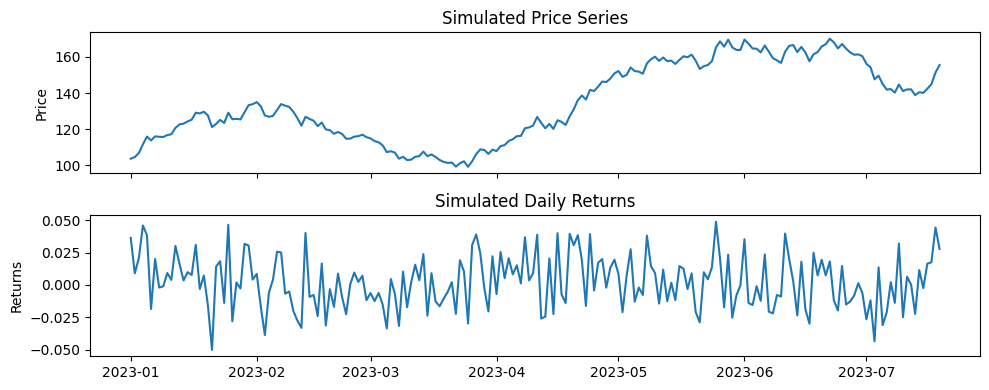

In [4]:
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(df.index, df['Price'])
ax[0].set_title('Simulated Price Series')
ax[0].set_ylabel('Price')

ax[1].plot(df.index, df['Returns'])
ax[1].set_title('Simulated Daily Returns')
ax[1].set_ylabel('Returns')

plt.tight_layout()
plt.show()

## 2. OLS Regression: Returns vs Lagged Returns
We regress today's return on yesterday's return to test for simple linear predictability.

In [5]:
df['Lag1'] = df['Returns'].shift(1)
df_reg = df.dropna().copy()

X = sm.add_constant(df_reg['Lag1'])
y = df_reg['Returns']

ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.2776
Date:                Tue, 18 Nov 2025   Prob (F-statistic):              0.599
Time:                        19:29:06   Log-Likelihood:                 492.93
No. Observations:                 199   AIC:                            -981.9
Df Residuals:                     197   BIC:                            -975.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.484      0.1

## 3. SARIMAX Modeling on the Price Series
Fit a SARIMAX model with weekly seasonality to the synthetic price series.

In [6]:
sarima_model = SARIMAX(
    df['Price'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7)
)

sarima_results = sarima_model.fit(disp=False)
print(sarima_results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Price   No. Observations:                  200
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -470.320
Date:                           Tue, 18 Nov 2025   AIC                            950.639
Time:                                   19:29:06   BIC                            966.927
Sample:                               01-01-2023   HQIC                           957.236
                                    - 07-19-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9399      0.114      8.242      0.000       0.716       1.163
ma.L1         -0.8947      0.138     -6.467

### 3.1 Actual vs Fitted Prices
Compare the SARIMAX fitted values with the actual synthetic price series.

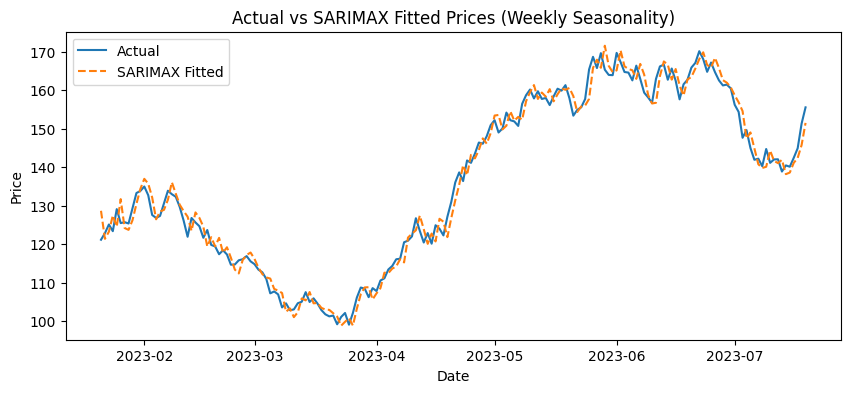

In [15]:
df['Fitted_SARIMAX'] = sarima_results.fittedvalues

plt.plot(df.index[20:], df['Price'][20:], label='Actual')
plt.plot(df.index[20:], df['Fitted_SARIMAX'][20:], linestyle='--', label='SARIMAX Fitted')
plt.title('Actual vs SARIMAX Fitted Prices (Weekly Seasonality)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## 4. Monte Carlo Simulation (30-Day Forecast)
Simulate 30-day price paths using normally distributed returns with a drift adjustment:
$$\mu_{drift} = \mu - \tfrac{1}{2}\sigma^2$$

In [8]:
mu, sigma = df['Returns'].mean(), df['Returns'].std()
mu_drift = mu - 0.5 * sigma**2

n_days = 30
n_paths = 1000
last_price = df['Price'].iloc[-1]

final_prices = []

for _ in range(n_paths):
    rand_returns = np.random.normal(mu_drift, sigma, n_days)
    price_path = last_price * (1 + rand_returns).cumprod()
    final_prices.append(price_path[-1])

final_prices = np.array(final_prices)

### 4.1 Distribution of Simulated Final Prices

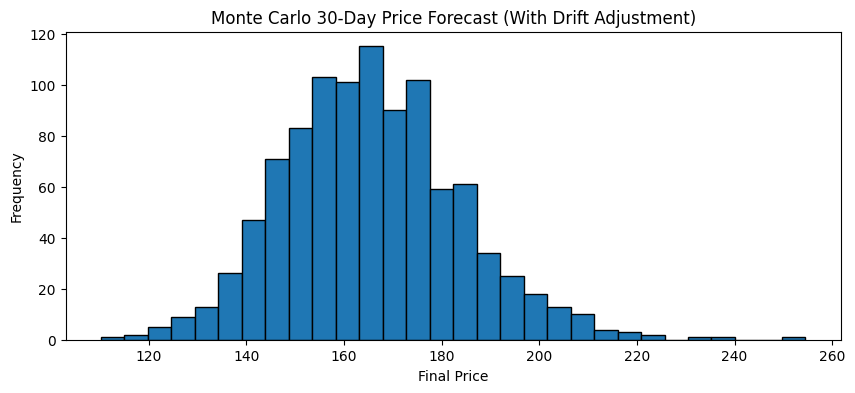

In [9]:
plt.hist(final_prices, bins=30, edgecolor='black')
plt.title('Monte Carlo 30-Day Price Forecast (With Drift Adjustment)')
plt.xlabel('Final Price')
plt.ylabel('Frequency')
plt.show()

## 4.2 90% Confidence Interval for Final Prices
We compute the 5th and 95th percentiles of the simulated distribution.

In [10]:
lower = np.percentile(final_prices, 5)
upper = np.percentile(final_prices, 95)

print(f'90% Confidence Interval: [{lower:.2f}, {upper:.2f}]')

90% Confidence Interval: [138.01, 197.38]


## 4.3 Full Path Simulation
Instead of only storing final prices, we simulate and store the entire 30-day paths.

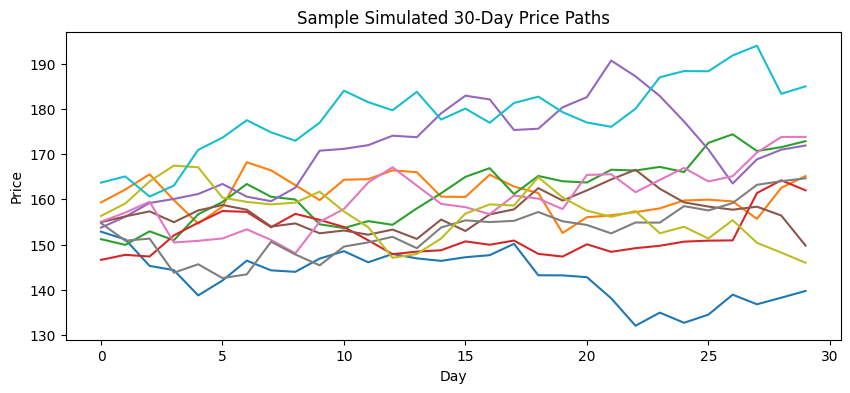

In [11]:
paths = np.zeros((n_paths, n_days))

for i in range(n_paths):
    rand_returns = np.random.normal(mu_drift, sigma, n_days)
    paths[i, :] = last_price * (1 + rand_returns).cumprod()

# Plot a subset of paths
for i in range(10):
    plt.plot(range(n_days), paths[i, :])
plt.title('Sample Simulated 30-Day Price Paths')
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

## 5. Summary
- Generated a synthetic financial time series (returns and prices).
- Performed OLS regression on returns vs lagged returns.
- Fit a SARIMAX(1,1,1)(1,1,1)ₗ model with weekly seasonality.
- Ran a Monte Carlo simulation with drift-adjusted returns.
- Computed a 90% confidence interval for 30-day ahead prices.
- Simulated full 30-day paths and visualized sample trajectories.

This workflow mirrors typical steps in quantitative research, risk analysis, and model validation.